**Resources**

* Dask best practices: https://docs.dask.org/en/latest/array-best-practices.html
* Xarray optimization tips: https://docs.xarray.dev/en/stable/user-guide/dask.html#chunking-and-performance

In [1]:
import earthaccess
import s3fs
import xarray as xr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from cartopy.crs import EqualEarth, PlateCarree
import xeofs as xe
import coiled
#from eofs.standard import Eof
from eofs.xarray import Eof
import dask

%matplotlib inline

In [2]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 12/23/2023
Using .netrc file for EDL


In [3]:
%%time

endpoints = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    #short_name="MUR25-JPL-L4-GLOB-v04.2",
    cloud_hosted=True,
    #temporal=("1910-01-01", "2008-02-01"),
    count=365
    )

Granules found: 7814
CPU times: user 95.2 ms, sys: 7.6 ms, total: 103 ms
Wall time: 57.9 s


In [4]:
# Thin out to two endpoints per month frequency:
endpoints_onepermonth = [endpoints[i] for i in range(len(endpoints)) if i%30==0]

In [5]:
%%time

fileobjs_onepermonth = earthaccess.open(endpoints_onepermonth)

 Opening 13 granules, approx size: 4.31 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 320 ms, sys: 25.2 ms, total: 345 ms
Wall time: 3.41 s


In [6]:
%%time

sstdata = xr.open_mfdataset(fileobjs_onepermonth, chunks={'time':2, 'lat':3000, 'lon':3000}, engine='h5netcdf')
#sstdata = xr.open_mfdataset(fileobjs_onepermonth, chunks={'time':6}, parallel=True, engine='h5netcdf') # Use if opening data with a distributed cluster.
sstdata

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 3000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 3000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 3000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 3000. T

CPU times: user 1.02 s, sys: 93.4 ms, total: 1.11 s
Wall time: 10.3 s


/opt/coiled/env/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 3000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 3000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset>
Dimensions:           (time: 13, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2003-05-2...
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [7]:
sstdata['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 13, lat: 17999, lon: 36000)>
dask.array<concatenate, shape=(13, 17999, 36000), dtype=float32, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2003-05-27T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

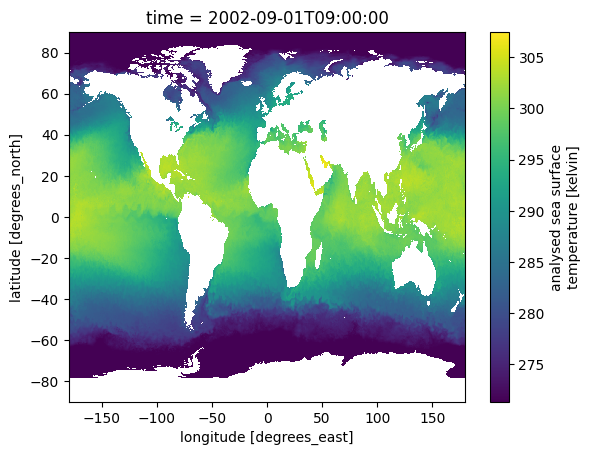

In [49]:
sstdata['analysed_sst'].isel(time=0).plot()

In [8]:
#sst_altchunk = sstdata['analysed_sst'].chunk({'time':1, 'lat':4000, 'lon':6000})
sst_altchunk = sstdata['analysed_sst'].chunk({'time':13, 'lat':1000, 'lon':2000})
#sst_altchunk = sstdata['analysed_sst'].chunk({'time':50, 'lat':1000, 'lon':2000})
sst_altchunk

<xarray.DataArray 'analysed_sst' (time: 13, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(13, 17999, 36000), dtype=float32, chunksize=(13, 1000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2003-05-27T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

### With dask

In [9]:
cluster = coiled.Cluster(n_workers=25, region='us-west-2')

Output()

Package - coiled_local_working, Built wheel does not contain all python files!

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                        ╷                                                                         │
│   Package              │ Note                                                                    │
│ ╶──────────────────────┼───────────────────────────────────────────────────────────────────────╴ │
│   coiled_local_synced  │ Source wheel built from /scratch/synced                                 │
│   coiled_local_working │ Source wheel built from                                                 │
│                        │ /opt/coiled/rt/.path-deps/coiled_local_working-0.0.0-py3-none-any.whl   │
│                        ╵                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│                            ╷                                                        ╷            │
│   Package                  │ Error                                                  │ Risk       │
│ ╶──────────────────────────┼────────────────────────────────────────────────────────┼──────────╴ │
│   coiled_local_working     │ Built wheel does not contain all python files!         │ Warning    │
│                            ╵                                                        ╵            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [14]:
#cluster=coiled.Cluster(name='podaac-science-b67bfee3')

In [10]:
client = cluster.get_client()
client

<Client: 'tls://10.0.62.173:8786' processes=25 threads=100, memory=371.15 GiB>

In [23]:
sst_persist = sst_altchunk.persist()

In [ ]:
%%time

# EOF fit
model = xe.models.EOF(n_modes=6)
#model.fit(sstdata['sst'], dim='time')
#model.fit(sst_persist, dim='time')
model.fit(sst_altchunk, dim='time')
#model.fit(sstdata['analysed_sst'], dim='time')

In [68]:
%%time

components = model.components().load()

CPU times: user 1.61 s, sys: 85.9 ms, total: 1.7 s
Wall time: 3.27 s


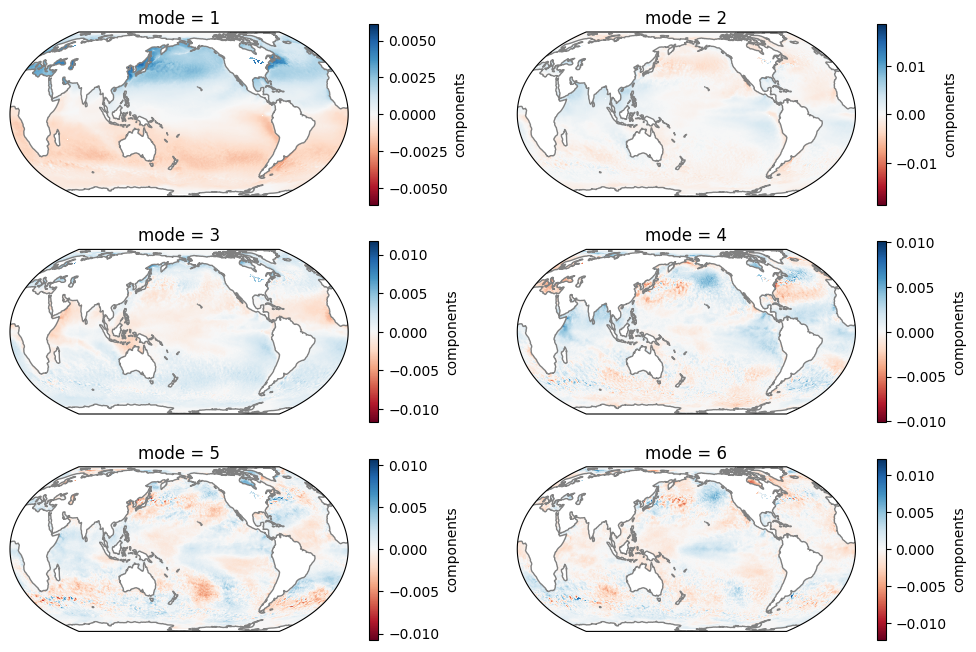

In [58]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, **kwargs)

In [70]:
#client.close()
cluster.shutdown()

## With `eofs` package

In [35]:
## Testing with a local cluster
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-thknm.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-thknm.dask.host/jupyter/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 14.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33111,Workers: 4
Dashboard: https://cluster-thknm.dask.host/jupyter/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 14.85 GiB
Comm: tcp://127.0.0.1:36203,Total threads: 1
Dashboard: https://cluster-thknm.dask.host/jupyter/proxy/44929/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:40109,


In [27]:
%%time

solver = Eof(
    sstdata['analysed_sst'],
    #sst_altchunk, 
    #weights = # v...
    center=True
    )

ValueError: error encountered in SVD, check that missing values are in the same places at each time and that all the values are not missing

In [23]:
sstdata['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 67, lat: 720, lon: 1440)>
dask.array<concatenate, shape=(67, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01T09:00:00 ... 2005-05-18T09:00:00
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    coverage_content_type:  physicalMeasurement
    units:                  kelvin
    valid_min:              -32767
    valid_max:              32767
    comment:                "Final" version using Multi-Resolution Variationa...
    source:                 MODIS_T-JPL, MODIS_A-JPL, AMSRE-REMSS, AVHRR17_G-...

In [29]:
nt, nlat, nlon = sstdata['analysed_sst'].shape

In [31]:
n_null = sstdata['analysed_sst'].isnull().sum(axis=0).compute().values.flatten()

In [32]:
n_nonan = (n_null == 0).sum() # Either no NANs
n_allnan = (n_null == nt).sum() # Or all NANs
len(n_null) == (n_nonan + n_allnan) # True if all gridpoints contain either all or no NANs.

True

In [33]:
n_allnan

344125

In [34]:
n_nonan

692675